# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.66' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree
# import jax; jax.config.update("jax_enable_x64", True)sss

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 3133
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)

SLURM_ARRAY_TASK_ID: 3133


In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.delta_obs = truth['obs'] - 1
model.block()
# model.render()

# CONFIG
{'a_lpt': 0.5,
 'a_obs': 0.5,
 'box_shape': array([320., 320., 320.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

2025-01-31 15:52:55.700997: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Run

### NUTS, HMC

# Warmupping...


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


MSEs: [3.6045814 3.6553214 3.68031   3.5548658] [3.6045814 3.6553214 3.68031   3.5548658]
mean_acc_prob: [0.6225076 0.6445055 0.6276173 0.6301718] 
ss: [0.0346114  0.07152883 0.03881174 0.0386797 ] 
mm_sqrt: {('init_mesh_',): Array([[1.0598253 , 3.3880396 , 1.9373021 , ..., 0.9935229 , 1.087187  ,
        0.7813363 ],
       [0.9412669 , 4.907551  , 3.4566197 , ..., 1.1154629 , 0.6633532 ,
        1.2175208 ],
       [1.3711346 , 4.215849  , 1.513938  , ..., 1.1010679 , 1.53812   ,
        0.90746456],
       [1.2304316 , 8.196559  , 1.7181865 , ..., 1.3215617 , 0.9846801 ,
        0.8963108 ]], dtype=float32)}
dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])


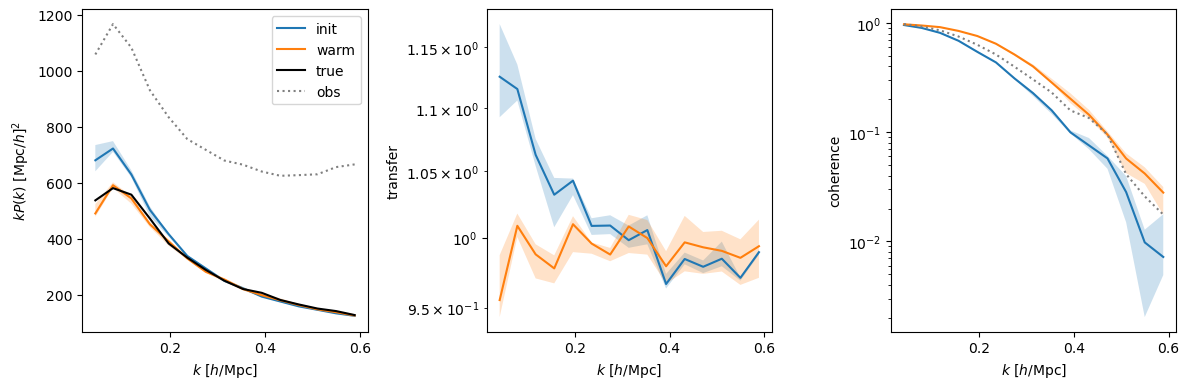

In [4]:
continue_run = False
if continue_run:
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    model.block()

    mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    print("# Warmupping...")
    init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(45), mcmc.num_chains))
    # init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)


    init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
    
    # mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
    # ils = mcmc.last_state.z
    
    ils = pload(save_path + "_init_last_state.p").z
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}


    ################
    from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    kpk0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    kpkobs = model.spectrum(truth['obs']-1)
    
    print(ils.keys(), init_params_.keys())

    mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    print("MSEs:", mse_, mse_)

    prob = 0.95
    plt.figure(figsize=(12, 4))
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    plot_powtranscoh(*kptcs__, fill=prob)
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    plot_powtranscoh(*kptcs_, fill=prob)
    plt.subplot(131)
    plot_pow(*kpk0, 'k', label='true')
    plot_pow(*kpkobs, ':', c='grey', label='obs')
    plt.legend()
    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    plt.tight_layout()
    # plt.savefig(save_dir+f'initpk_{task_id}.png')
    plt.savefig(f'init_glin_{task_id}.png')

    last_state = pload(save_path + "_init_last_state.p")
    print("mean_acc_prob:", last_state.mean_accept_prob, 
        "\nss:", last_state.adapt_state.step_size, 
        "\nmm_sqrt:", last_state.adapt_state.mass_matrix_sqrt)
    ################
    
    init_params_ |= ils
    # init_params_ |= mcmc.last_state.z
    print(init_params_.keys())
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()

In [5]:
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run

n_samples, n_runs, n_chains = 2*8192, 2, 4 # 8192
# config = {'L':256., 'step_size': 2.,} # 256, 2 for 32^3
config = {'L':128*8**.5, 'step_size': 4,} # 256, 2 for 32^3
# config = None

warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_samples, config=config)))
state, config = warmup_fn(jr.split(jr.key(42), n_chains), init_params_)
print(config)
pdump(state, save_path+f"_last_state.p")
pdump(config, save_path+f"_conf.p")

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


MCLMCAdaptationState(L=Array([362.03867, 362.03867, 362.03867, 362.03867],      dtype=float32, weak_type=True), step_size=Array([4, 4, 4, 4], dtype=int32, weak_type=True), sqrt_diag_cov=Array([1., 1., 1., 1.], dtype=float32, weak_type=True))


In [ ]:
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
# state = pload(save_path+f"_last_state.p")
# config = pload(save_path+f"_conf.p")
n_samples, n_runs, n_chains = 64, 5, 4 # 8192

thinning = 128
run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))
key = jr.key(42)

for i_run in range(1, n_runs+1):
    print(f"run {i_run}/{n_runs}")
    key, run_key = jr.split(key, 2)
    state, samples = run_fn(jr.split(run_key, n_chains), state, config)
    
    jnp.savez(save_path+f"_{i_run}.npz", **samples)
    pdump(state, save_path+f"_last_state.p")

run 1/5


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


run 2/5


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


run 3/5
run 4/5


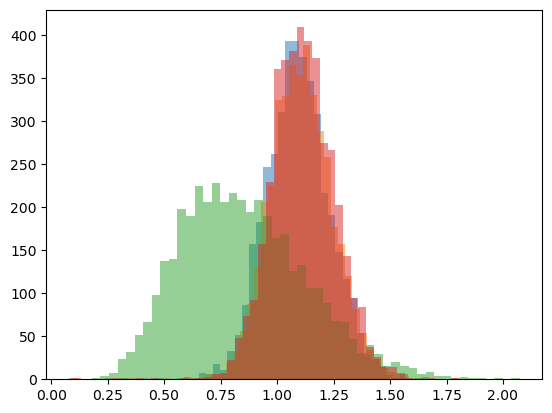

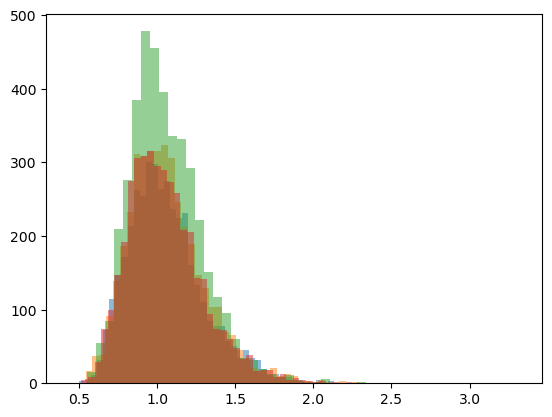

In [ ]:
# MCLMC mm vs NUTS mm
for i in range(4):
    a  = out[1].sqrt_diag_cov[i]
    plt.hist(a, bins=50, alpha=0.5)
plt.figure()
for i in range(4):
    a  = last_state.adapt_state.mass_matrix_sqrt[('init_mesh_',)][i]
    plt.hist(a, bins=50, alpha=0.5)

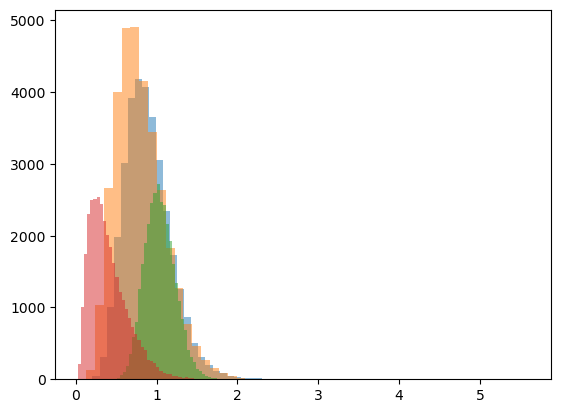

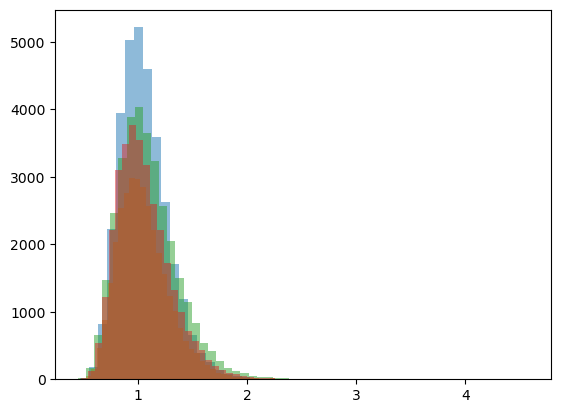

In [ ]:
# MCLMC mm vs NUTS mm
for i in range(4):
    a  = out[1].sqrt_diag_cov[i]
    plt.hist(a, bins=50, alpha=0.5)
plt.figure()
for i in range(4):
    a  = last_state.adapt_state.mass_matrix_sqrt[('init_mesh_',)][i]
    plt.hist(a, bins=50, alpha=0.5)

In [ ]:
if mcmc_config['sampler'] != 'NUTSwG':
    mcmc = get_mcmc(model.model, mcmc_config)

    # mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)

    mcmc.num_warmup = 0
    mcmc.post_warmup_state = pload(save_path + "_last_state.p")
    mcmc_runned = sample_and_save(mcmc, save_path, 2, mcmc_config['n_runs'], rng=43, extra_fields=['num_steps'])
else:
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)
    warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'])))
    state = jit(vmap(init_state_fn))(init_params_)


    samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), state)
    print("conf:", conf,
            "\n\ninfos:", infos, '\n#################\n')
    jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    pdump(state, save_path+f"_last_state.p")
    pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, mcmc_config['n_samples'])))
    start = 1
    end = start + mcmc_config['n_runs']-1
    key = jr.key(42)
    for i_run in range(start, end+1):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, mcmc_config['n_chains']), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")